# Chain CRF Simulation

In [1]:
import sys 
sys.path.append('..')

In [2]:
from chaincrf import ChainCRFSimulation

In [3]:
import torch
import seaborn as sns
import pandas as pd
import numpy as np
from pandas import DataFrame
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import Adam

In [4]:
%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
!nvidia-smi

Sun Dec  5 21:48:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 15%   37C    P0    24W / 250W |      0MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:DB:00.0 Off |                  N/A |
| 27%   

In [7]:
batch_size = 1
max_len = 10
num_states = 10000
hidden_size = 50
chaincrf = ChainCRFSimulation(batch_size, max_len, num_states, hidden_size).to('cuda')

In [8]:
with torch.no_grad():
    log_Z = chaincrf.log_partition()

In [9]:
log_Z

tensor([118.0542], device='cuda:0')

## Compare topK function definition

In [46]:
def compare_topk(treecrf, proposal='localglobal', N=100, K1=None, K2=None, yloc=[0.2, 0.2], offset=0.1, xlim=None, draw_topk=True):
    with torch.no_grad():
        log_z_exact = treecrf.log_partition()
        log_z_exact = log_z_exact[0].cpu().item()
        log_z_ksum_25 = treecrf.log_partition_approx(K1=500, topk_only=True).cpu().item()
        log_z_ksum_50 = treecrf.log_partition_approx(K1=1000, topk_only=True).cpu().item()

        log_z_est_20 = []
        log_z_est_200 = []
        log_z_est_400 = []
        log_z_est_1000 = []
        for _ in tqdm(range(N)):
            est = treecrf.log_partition_approx(K1=K1[0], K2=K2[0], proposal=proposal)
            log_z_est_20.append(est[0].cpu().item())

            est = treecrf.log_partition_approx(K1=K1[1], K2=K2[1], proposal=proposal)
            log_z_est_200.append(est[0].cpu().item())

            est = treecrf.log_partition_approx(K1=K1[2], K2=K2[2], proposal=proposal)
            log_z_est_400.append(est[0].cpu().item())
            
#             est = treecrf.log_partition_approx(K1=500, K2=500, proposal=proposal)
#             log_z_est_1000.append(est[0].cpu().item())

        estimates = pd.DataFrame(
            {
             'estimates': np.array(
                 log_z_est_20 + log_z_est_200 + log_z_est_400 
#                  + log_z_est_1000
             ), 
             'memory': np.array(
                                  ['1%'] * N
                                  + ['10%'] * N
                                  + ['20%'] * N
#                                   + ['50%'] * N
                                 )}
            )

        plt.figure(figsize=(4,2))
        ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2)
        ax.set(ylabel=None)
        plt.axvline(x=log_z_exact, color='#CC2F27')
        
        if(draw_topk):
            plt.axvline(x=log_z_ksum_25, color='gray')
            plt.axvline(x=log_z_ksum_50, color='gray')
            plt.text(log_z_ksum_25+offset, yloc[0], 'TopK Sum\n25% Mem', size=9)
            plt.text(log_z_ksum_50+offset, yloc[1], 'TopK Sum\n50% Mem', size=9)
        
        plt.tick_params(axis='both', which='both', left=False, bottom=True, right=False, top=False, labelleft=False, labelbottom=True) 
        # move_legend(ax, 'upper left')
        plt.xlim(xlim)
        
        print('bias:')
        print(log_z_ksum_25 - log_z_exact, 
              log_z_ksum_50 - log_z_exact, 
              np.mean(log_z_est_20) - log_z_exact, 
              np.mean(log_z_est_200) - log_z_exact, 
              np.mean(log_z_est_400) - log_z_exact,
#               np.mean(log_z_est_1000) - log_z_exact
             )
        print('variance:')
        print(np.var(log_z_est_20), np.var(log_z_est_200), np.var(log_z_est_400),
#               np.var(log_z_est_1000)
             )
        print('mse')
        print((log_z_ksum_25 - log_z_exact)**2, 
              (log_z_ksum_50 - log_z_exact)**2, 
              np.mean((np.array(log_z_est_20) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_200) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_400) - log_z_exact)**2),
#               np.mean((np.array(log_z_est_1000) - log_z_exact)**2)
             )
    return 

## Compare entropy

In [54]:
def compare_topk_ent(chaincrf, proposal='localglobal', N=100, K1=None, K2=None, yloc=[0.2, 0.2], offset=0.1, xlim=None, draw_topk=True):
    with torch.no_grad():
        ent_exact = chaincrf.entropy()
        ent_exact = ent_exact[0].cpu().item()
        ent_ksum_25 = chaincrf.entropy_approx(K1=500, topk_only=True).cpu().item()
        ent_ksum_50 = chaincrf.entropy_approx(K1=1000, topk_only=True).cpu().item()

        ent_est_20 = []
        ent_est_200 = []
        ent_est_400 = []
        ent_est_1000 = []
        for _ in tqdm(range(N)):
            est = chaincrf.entropy_approx(K1=K1[0], K2=K2[0], proposal=proposal)
            ent_est_20.append(est[0].cpu().item())

            est = chaincrf.entropy_approx(K1=K1[1], K2=K2[1], proposal=proposal)
            ent_est_200.append(est[0].cpu().item())

            est = chaincrf.entropy_approx(K1=K1[2], K2=K2[2], proposal=proposal)
            ent_est_400.append(est[0].cpu().item())
            
#             est = treecrf.log_partition_approx(K1=500, K2=500, proposal=proposal)
#             log_z_est_1000.append(est[0].cpu().item())

        estimates = pd.DataFrame(
            {
             'estimates': np.array(
                 ent_est_20 + ent_est_200 + ent_est_400 
#                  + log_z_est_1000
             ), 
             'memory': np.array(
                                  ['1%'] * N
                                  + ['10%'] * N
                                  + ['20%'] * N
#                                   + ['50%'] * N
                                 )}
            )

        plt.figure(figsize=(4,2))
        ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2)
        ax.set(ylabel=None)
        plt.axvline(x=ent_exact, color='#CC2F27')
        
        if(draw_topk):
            plt.axvline(x=ent_ksum_25, color='gray')
            plt.axvline(x=ent_ksum_50, color='gray')
            plt.text(ent_ksum_25+offset, yloc[0], 'TopK Sum\n25% Mem', size=9)
            plt.text(ent_ksum_50+offset, yloc[1], 'TopK Sum\n50% Mem', size=9)
        
        plt.tick_params(axis='both', which='both', left=False, bottom=True, right=False, top=False, labelleft=False, labelbottom=True) 
        # move_legend(ax, 'upper left')
        plt.xlim(xlim)
        
        print('bias:')
        print(ent_ksum_25 - ent_exact, 
              ent_ksum_50 - ent_exact, 
              np.mean(ent_est_20) - ent_exact, 
              np.mean(ent_est_200) - ent_exact, 
              np.mean(ent_est_400) - ent_exact,
#               np.mean(log_z_est_1000) - log_z_exact
             )
        print('variance:')
        print(np.var(ent_est_20), np.var(ent_est_200), np.var(ent_est_400),
#               np.var(log_z_est_1000)
             )
        print('mse')
        print((ent_ksum_25 - ent_exact)**2, 
              (ent_ksum_50 - ent_exact)**2, 
              np.mean((np.array(ent_est_20) - ent_exact)**2), 
              np.mean((np.array(ent_est_200) - ent_exact)**2), 
              np.mean((np.array(ent_est_400) - ent_exact)**2),
#               np.mean((np.array(log_z_est_1000) - log_z_exact)**2)
             )
    return 

# Dense Case

In [34]:
batch_size = 1
max_len = 10
num_states = 10000
hidden_size = 50
chaincrf_d = ChainCRFSimulation(batch_size, max_len, num_states, hidden_size).to('cuda')
print(chaincrf_d.entropy_local())

optimizer = Adam(chaincrf_d.parameters(), lr=1e-4)
for _ in tqdm(range(10)):
    chaincrf_d.zero_grad()
    ent = chaincrf_d.entropy_local()
    ent.backward()
    optimizer.step()
print(ent)

100%|██████████| 10/10 [00:00<00:00, 494.03it/s]

tensor(8.5488, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.5288, device='cuda:0', grad_fn=<MeanBackward0>)


## partition

100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


bias:
-2.5288772583007812 -1.4608535766601562 -0.39867225646972315 0.018244857788090485 -0.0009609222412052532
variance:
0.5895151403893891 0.02428671410062234 0.004699619523453293
mse
6.395220187550876 2.134093172440771 0.7484547084680525 0.02461958893632982 0.004700542895006947


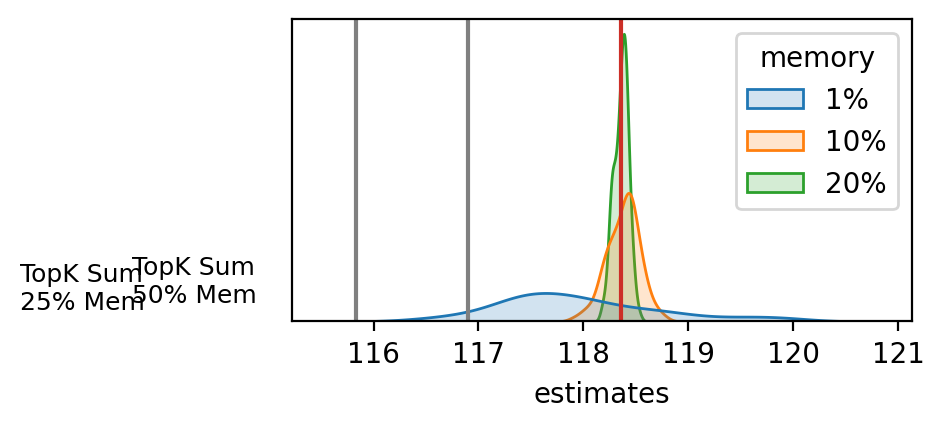

In [49]:
K1 = [99, 999, 1999]
K2 = [1, 1, 1]
compare_topk(chaincrf_d, proposal='softmax', N=100, K1=K1, K2=K2, yloc=[0.08, 0.13], offset=-3.2)

## Entropy

100%|██████████| 100/100 [00:12<00:00,  7.71it/s]


bias:
-15.081794738769531 -9.22296142578125 -0.7736635208129883 -0.034261932373048865 -0.03934089660644702
variance:
5.852110196647809 0.5122542626298149 0.14253771535847914
mse
227.4605325423763 85.06301746144891 6.450665440084558 0.5134281426397501 0.1440854215042782


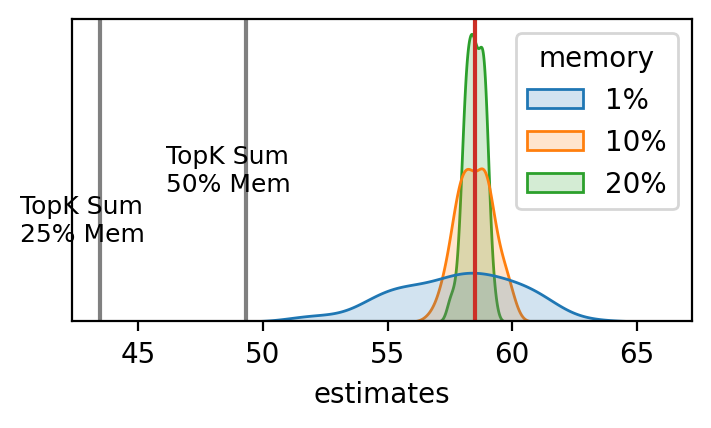

In [60]:
K1 = [99, 999, 1999]
K2 = [1, 1, 1]
compare_topk_ent(chaincrf_d, proposal='softmax', N=100, K1=K1, K2=K2, yloc=[0.08, 0.13], offset=-3.2)

# Intermediate

In [38]:
batch_size = 1
max_len = 10
num_states = 10000
hidden_size = 50
chaincrf_i = ChainCRFSimulation(batch_size, max_len, num_states, hidden_size).to('cuda')
print(chaincrf_i.entropy_local())

optimizer = Adam(chaincrf_i.parameters(), lr=1e-4)
for _ in tqdm(range(30)):
    chaincrf_i.zero_grad()
    ent = chaincrf_i.entropy_local()
    ent.backward()
    optimizer.step()
print(ent)

100%|██████████| 30/30 [00:00<00:00, 552.77it/s]

tensor(8.5246, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.4555, device='cuda:0', grad_fn=<MeanBackward0>)


## Partition

100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


bias:
-2.6449737548828125 -1.4188766479492188 -0.33123367309570995 -0.036383285522461506 0.06692436218261832
variance:
0.6575494059017162 0.02833462033660035 0.4420643898228825
mse
6.995886164018884 2.0132109420956112 0.7672651520941872 0.02965836380200926 0.44654326007643247


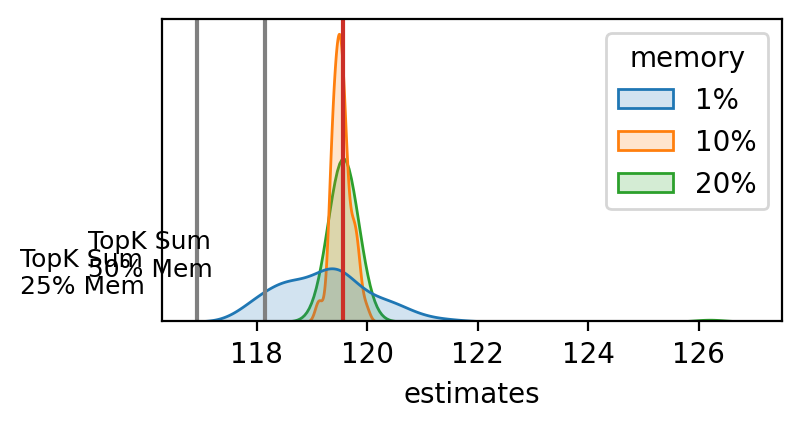

In [55]:
K1 = [99, 999, 1999]
K2 = [1, 1, 1]
compare_topk(chaincrf_i, proposal='softmax', N=100, K1=K1, K2=K2, yloc=[0.08, 0.13], offset=-3.2)

## Entropy

100%|██████████| 100/100 [00:12<00:00,  7.89it/s]


bias:
-13.113883972167969 -7.738075256347656 -1.0128122329711928 0.01715061187744027 0.017155494689944817
variance:
5.354165113300951 1.5393985489465571 0.08028667060230363
mse
171.97395283548394 59.877808672899846 6.379953732557042 1.539692692434328 0.08058098160036024


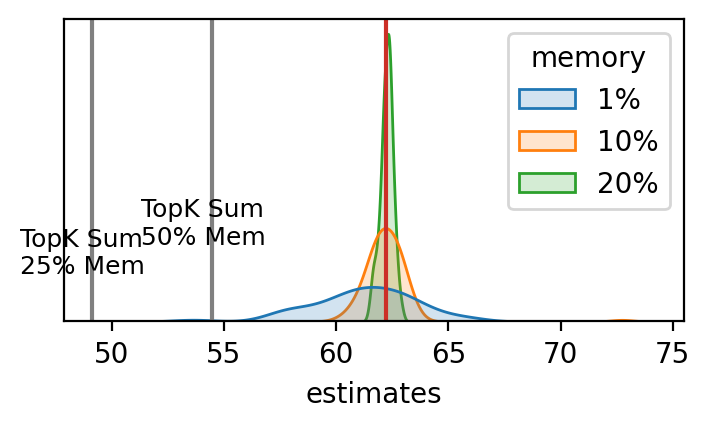

In [58]:
K1 = [99, 999, 1999]
K2 = [1, 1, 1]
compare_topk_ent(chaincrf_i, proposal='softmax', N=100, K1=K1, K2=K2, yloc=[0.08, 0.13], offset=-3.2)

# Long Tail

In [40]:
batch_size = 1
max_len = 10
num_states = 10000
hidden_size = 50
chaincrf_l = ChainCRFSimulation(batch_size, max_len, num_states, hidden_size).to('cuda')
print(chaincrf_l.entropy_local())

optimizer = Adam(chaincrf_l.parameters(), lr=1e-4)
for _ in tqdm(range(50)):
    chaincrf_l.zero_grad()
    ent = chaincrf_l.entropy_local()
    ent.backward()
    optimizer.step()
print(ent)

100%|██████████| 50/50 [00:00<00:00, 580.44it/s]

tensor(8.5115, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.3820, device='cuda:0', grad_fn=<MeanBackward0>)


## Partition

100%|██████████| 100/100 [00:11<00:00,  8.82it/s]


bias:
-2.5260696411132812 -1.2835311889648438 -0.31229385375976904 -0.001543197631832527 0.00040679931640852374
variance:
0.636730214236281 0.02451279418409686 0.0038058902380056674
mse
6.3810278317541815 1.6474523130455054 0.7342576653324068 0.02451517564302776 0.0038060557236894964


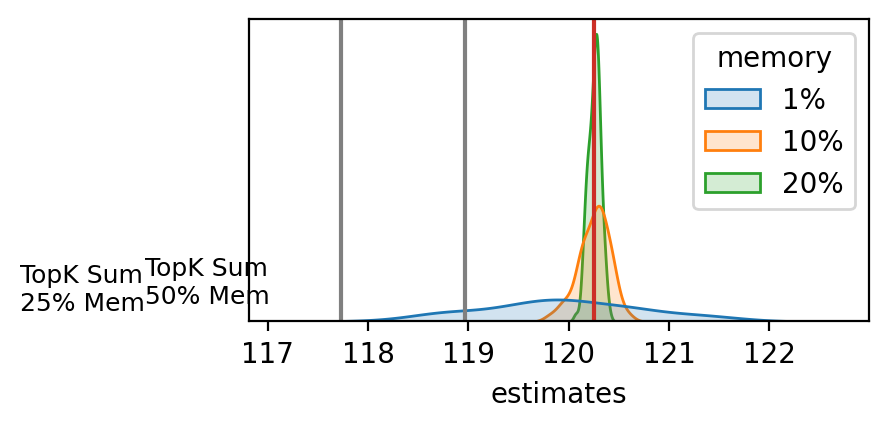

In [53]:
K1 = [99, 999, 1999]
K2 = [1, 1, 1]
compare_topk(chaincrf_l, proposal='softmax', N=100, K1=K1, K2=K2, yloc=[0.08, 0.13], offset=-3.2)

## Entropy

100%|██████████| 100/100 [00:12<00:00,  7.72it/s]


bias:
-11.912948608398438 -6.844932556152344 -0.38829719543456775 -0.13011642456054773 -0.011948928833007244
variance:
4.0001996211069 0.2582578396011726 0.06788876423414913
mse
141.91834454634227 46.85310169827426 4.150974333089253 0.2751881235415931 0.06803154113440542


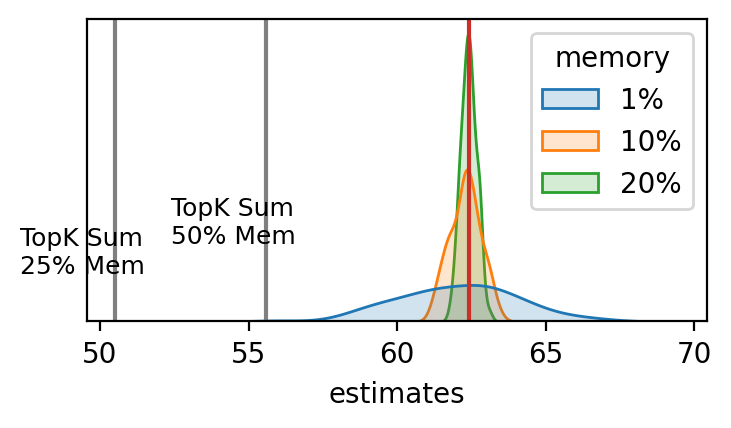

In [59]:
K1 = [99, 999, 1999]
K2 = [1, 1, 1]
compare_topk_ent(chaincrf_l, proposal='softmax', N=100, K1=K1, K2=K2, yloc=[0.08, 0.13], offset=-3.2)